# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [288]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

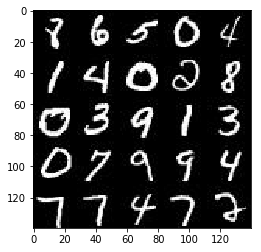

In [289]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import pickle as pkl
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

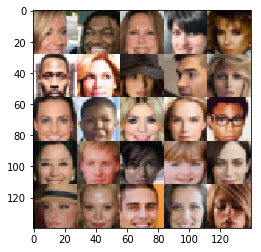

In [290]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [291]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/usr/local/anaconda3/envs/dlnd/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [292]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="z_dim")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [293]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # images: 28x28xC
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        alpha=0.2
        x1 = tf.layers.conv2d(images, 128, 5, 
                              strides=2, 
                              padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1,0.8)
        # x1: 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 256, 5, 
                              strides=2, 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2,0.8)
        # x2: 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 512, 5, 
                              strides=2, 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3,0.8)
        # x3: 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
#     print("discriminator out shape: ", out.shape)
#     print("discriminator logits shape: ", logits.shape)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [294]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x256 now
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 
                                        strides=1, 
                                        padding='valid',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
#         print("z shape: ", z.shape)
#         print("x1 shape",x1.shape)
#         print("x2 shape",x2.shape)
#         print("x3 shape",x3.shape)
#         print("logits shape",logits.shape)
        out = tf.tanh(logits)
#     print("generator shape: ", out.shape)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [295]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.9
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [296]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [297]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [298]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print("data_shape:", data_shape)
    print_every = 10
    show_every = 100
    image_channel = 1 if data_image_mode == 'L' else 3
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],image_channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channel)
    d_train_opt, g_train_opt = model_opt(d_loss,g_loss,learning_rate, beta1)
    steps = 0 
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channel, data_image_mode)
        saver = tf.train.Saver()
        saver.save(sess, './checkpoints/generator.ckpt')
    return losses            

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

mnist_dataset.shape:  (60000, 28, 28, 1)
mnist_dataset.image_mode:  L
data_shape: (60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.4028... Generator Loss: 5.7765
Epoch 1/2... Discriminator Loss: 0.4677... Generator Loss: 8.8576
Epoch 1/2... Discriminator Loss: 1.6183... Generator Loss: 30.7700
Epoch 1/2... Discriminator Loss: 0.6669... Generator Loss: 19.5840
Epoch 1/2... Discriminator Loss: 0.5492... Generator Loss: 2.9224
Epoch 1/2... Discriminator Loss: 0.3999... Generator Loss: 4.3749
Epoch 1/2... Discriminator Loss: 0.3870... Generator Loss: 4.7190
Epoch 1/2... Discriminator Loss: 0.4261... Generator Loss: 3.9987
Epoch 1/2... Discriminator Loss: 0.6305... Generator Loss: 22.9647
Epoch 1/2... Discriminator Loss: 0.4380... Generator Loss: 4.4062


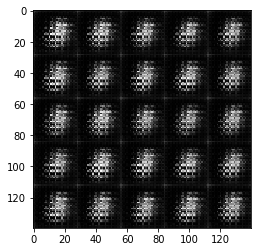

Epoch 1/2... Discriminator Loss: 0.4111... Generator Loss: 4.6985
Epoch 1/2... Discriminator Loss: 0.3918... Generator Loss: 3.4928
Epoch 1/2... Discriminator Loss: 0.3734... Generator Loss: 5.0257
Epoch 1/2... Discriminator Loss: 0.3851... Generator Loss: 4.5320
Epoch 1/2... Discriminator Loss: 0.3664... Generator Loss: 4.3466
Epoch 1/2... Discriminator Loss: 0.3872... Generator Loss: 3.7598
Epoch 1/2... Discriminator Loss: 0.3783... Generator Loss: 5.0051
Epoch 1/2... Discriminator Loss: 0.3686... Generator Loss: 5.0578
Epoch 1/2... Discriminator Loss: 0.3536... Generator Loss: 5.2096
Epoch 1/2... Discriminator Loss: 0.3671... Generator Loss: 5.1875


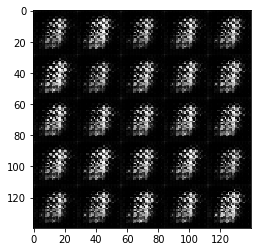

Epoch 1/2... Discriminator Loss: 0.3536... Generator Loss: 4.8227
Epoch 1/2... Discriminator Loss: 0.3770... Generator Loss: 4.3948
Epoch 1/2... Discriminator Loss: 0.4352... Generator Loss: 3.0033
Epoch 1/2... Discriminator Loss: 0.3563... Generator Loss: 4.9326
Epoch 1/2... Discriminator Loss: 0.3871... Generator Loss: 5.2630
Epoch 1/2... Discriminator Loss: 0.3662... Generator Loss: 4.9273
Epoch 1/2... Discriminator Loss: 0.4182... Generator Loss: 5.6998
Epoch 1/2... Discriminator Loss: 0.3647... Generator Loss: 4.3466
Epoch 1/2... Discriminator Loss: 0.3662... Generator Loss: 4.2115
Epoch 1/2... Discriminator Loss: 0.3623... Generator Loss: 4.2568


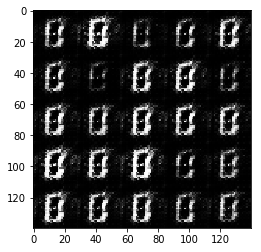

Epoch 1/2... Discriminator Loss: 0.3818... Generator Loss: 6.1144
Epoch 1/2... Discriminator Loss: 0.3567... Generator Loss: 5.0756
Epoch 1/2... Discriminator Loss: 0.3604... Generator Loss: 4.6559
Epoch 1/2... Discriminator Loss: 0.3939... Generator Loss: 3.3884
Epoch 1/2... Discriminator Loss: 0.3906... Generator Loss: 4.6781
Epoch 1/2... Discriminator Loss: 0.3618... Generator Loss: 4.3204
Epoch 1/2... Discriminator Loss: 0.3859... Generator Loss: 4.4021
Epoch 1/2... Discriminator Loss: 0.3497... Generator Loss: 6.0130
Epoch 1/2... Discriminator Loss: 0.3690... Generator Loss: 4.2618
Epoch 1/2... Discriminator Loss: 0.3555... Generator Loss: 4.5030


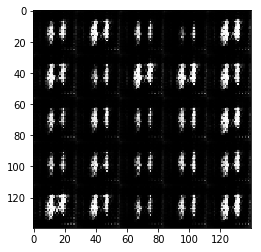

Epoch 1/2... Discriminator Loss: 0.3450... Generator Loss: 4.9219
Epoch 1/2... Discriminator Loss: 0.3802... Generator Loss: 4.8690
Epoch 1/2... Discriminator Loss: 0.3593... Generator Loss: 4.4161
Epoch 1/2... Discriminator Loss: 0.3668... Generator Loss: 4.3473
Epoch 1/2... Discriminator Loss: 0.3833... Generator Loss: 3.5721
Epoch 1/2... Discriminator Loss: 0.3570... Generator Loss: 4.8399
Epoch 1/2... Discriminator Loss: 0.3771... Generator Loss: 4.8662
Epoch 1/2... Discriminator Loss: 0.3513... Generator Loss: 4.5633
Epoch 1/2... Discriminator Loss: 0.3627... Generator Loss: 4.4959
Epoch 1/2... Discriminator Loss: 0.3710... Generator Loss: 4.2846


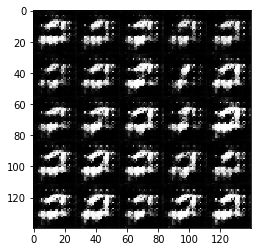

Epoch 1/2... Discriminator Loss: 0.3718... Generator Loss: 3.9986
Epoch 1/2... Discriminator Loss: 0.3831... Generator Loss: 3.5960
Epoch 1/2... Discriminator Loss: 0.3873... Generator Loss: 4.0250
Epoch 1/2... Discriminator Loss: 0.3781... Generator Loss: 3.5311
Epoch 1/2... Discriminator Loss: 0.3886... Generator Loss: 3.5800
Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 4.0982
Epoch 1/2... Discriminator Loss: 0.3767... Generator Loss: 3.8657
Epoch 1/2... Discriminator Loss: 0.3706... Generator Loss: 4.4407
Epoch 1/2... Discriminator Loss: 0.3782... Generator Loss: 3.7915
Epoch 1/2... Discriminator Loss: 0.3756... Generator Loss: 4.0999


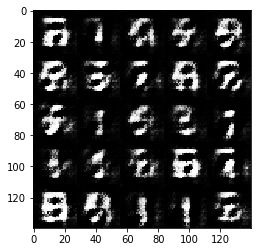

Epoch 1/2... Discriminator Loss: 0.3895... Generator Loss: 3.9059
Epoch 1/2... Discriminator Loss: 0.3836... Generator Loss: 3.5035
Epoch 1/2... Discriminator Loss: 0.4478... Generator Loss: 2.8539
Epoch 1/2... Discriminator Loss: 0.4012... Generator Loss: 3.5803
Epoch 1/2... Discriminator Loss: 0.3919... Generator Loss: 3.0922
Epoch 1/2... Discriminator Loss: 0.3834... Generator Loss: 3.7056
Epoch 1/2... Discriminator Loss: 0.3843... Generator Loss: 3.4432
Epoch 1/2... Discriminator Loss: 0.3834... Generator Loss: 4.1240
Epoch 1/2... Discriminator Loss: 0.3803... Generator Loss: 3.8410
Epoch 1/2... Discriminator Loss: 0.3813... Generator Loss: 3.5413


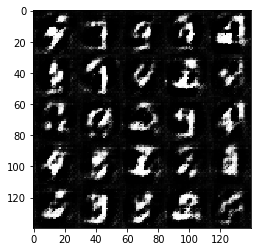

Epoch 1/2... Discriminator Loss: 0.3778... Generator Loss: 3.4316
Epoch 1/2... Discriminator Loss: 0.3876... Generator Loss: 3.6466
Epoch 1/2... Discriminator Loss: 0.4061... Generator Loss: 3.1366
Epoch 1/2... Discriminator Loss: 0.3818... Generator Loss: 3.4430
Epoch 1/2... Discriminator Loss: 0.3984... Generator Loss: 3.3740
Epoch 1/2... Discriminator Loss: 0.3951... Generator Loss: 3.1736
Epoch 1/2... Discriminator Loss: 0.3929... Generator Loss: 3.5284
Epoch 1/2... Discriminator Loss: 0.3969... Generator Loss: 3.3863
Epoch 1/2... Discriminator Loss: 0.4296... Generator Loss: 2.6482
Epoch 1/2... Discriminator Loss: 0.4064... Generator Loss: 3.8110


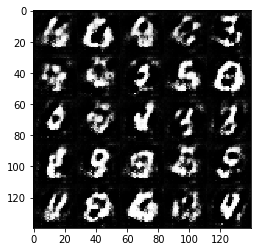

Epoch 1/2... Discriminator Loss: 0.4028... Generator Loss: 3.7274
Epoch 1/2... Discriminator Loss: 0.3866... Generator Loss: 3.5219
Epoch 1/2... Discriminator Loss: 0.4003... Generator Loss: 4.0183
Epoch 1/2... Discriminator Loss: 0.3996... Generator Loss: 3.2822
Epoch 1/2... Discriminator Loss: 0.3908... Generator Loss: 3.5172
Epoch 1/2... Discriminator Loss: 0.4196... Generator Loss: 2.7062
Epoch 1/2... Discriminator Loss: 0.4041... Generator Loss: 3.5263
Epoch 1/2... Discriminator Loss: 0.3975... Generator Loss: 3.2000
Epoch 1/2... Discriminator Loss: 0.3965... Generator Loss: 3.2025
Epoch 1/2... Discriminator Loss: 0.3949... Generator Loss: 3.6539


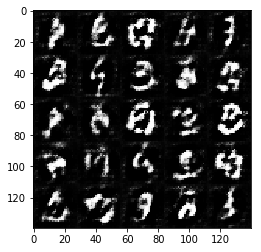

Epoch 1/2... Discriminator Loss: 0.3972... Generator Loss: 3.6256
Epoch 1/2... Discriminator Loss: 0.4006... Generator Loss: 3.1782
Epoch 1/2... Discriminator Loss: 0.3920... Generator Loss: 3.0430
Epoch 1/2... Discriminator Loss: 0.3961... Generator Loss: 3.5054
Epoch 1/2... Discriminator Loss: 0.3825... Generator Loss: 3.4735
Epoch 1/2... Discriminator Loss: 0.3844... Generator Loss: 3.4219
Epoch 1/2... Discriminator Loss: 0.3841... Generator Loss: 3.4906
Epoch 1/2... Discriminator Loss: 0.3952... Generator Loss: 3.7875
Epoch 1/2... Discriminator Loss: 0.3993... Generator Loss: 3.0574
Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 3.5095


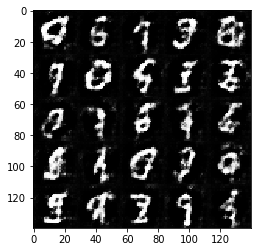

Epoch 1/2... Discriminator Loss: 0.3978... Generator Loss: 3.1228
Epoch 1/2... Discriminator Loss: 0.3824... Generator Loss: 3.6430
Epoch 1/2... Discriminator Loss: 0.3616... Generator Loss: 3.6349
Epoch 1/2... Discriminator Loss: 0.3906... Generator Loss: 3.0710
Epoch 1/2... Discriminator Loss: 0.3896... Generator Loss: 3.1646
Epoch 1/2... Discriminator Loss: 0.4108... Generator Loss: 3.1423
Epoch 1/2... Discriminator Loss: 0.3801... Generator Loss: 4.3468
Epoch 1/2... Discriminator Loss: 0.4003... Generator Loss: 3.2610
Epoch 1/2... Discriminator Loss: 0.4051... Generator Loss: 3.2447
Epoch 1/2... Discriminator Loss: 0.3716... Generator Loss: 3.6379


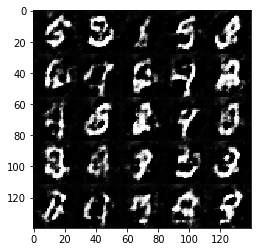

Epoch 1/2... Discriminator Loss: 0.4152... Generator Loss: 2.9485
Epoch 1/2... Discriminator Loss: 0.3787... Generator Loss: 3.8775
Epoch 1/2... Discriminator Loss: 0.3819... Generator Loss: 3.4135
Epoch 1/2... Discriminator Loss: 0.4073... Generator Loss: 3.0009
Epoch 1/2... Discriminator Loss: 0.3959... Generator Loss: 3.3024
Epoch 1/2... Discriminator Loss: 0.3833... Generator Loss: 3.1168
Epoch 1/2... Discriminator Loss: 0.3912... Generator Loss: 3.2731
Epoch 1/2... Discriminator Loss: 0.3773... Generator Loss: 3.3899
Epoch 1/2... Discriminator Loss: 0.3820... Generator Loss: 3.5487
Epoch 1/2... Discriminator Loss: 0.3821... Generator Loss: 3.2519


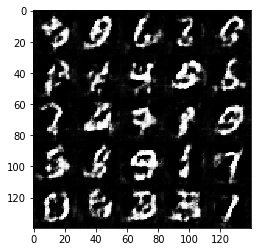

Epoch 1/2... Discriminator Loss: 0.4074... Generator Loss: 2.8875
Epoch 1/2... Discriminator Loss: 0.3847... Generator Loss: 3.6324
Epoch 1/2... Discriminator Loss: 0.4055... Generator Loss: 3.2019
Epoch 1/2... Discriminator Loss: 0.3900... Generator Loss: 3.5871
Epoch 1/2... Discriminator Loss: 0.3805... Generator Loss: 3.2019
Epoch 1/2... Discriminator Loss: 0.3905... Generator Loss: 3.7346
Epoch 1/2... Discriminator Loss: 0.3871... Generator Loss: 3.2636
Epoch 1/2... Discriminator Loss: 0.4030... Generator Loss: 3.1197
Epoch 1/2... Discriminator Loss: 0.3992... Generator Loss: 3.7274
Epoch 1/2... Discriminator Loss: 0.3847... Generator Loss: 3.6802


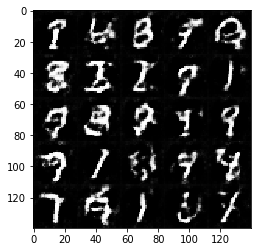

Epoch 1/2... Discriminator Loss: 0.3799... Generator Loss: 3.1750
Epoch 1/2... Discriminator Loss: 0.3965... Generator Loss: 3.2774
Epoch 1/2... Discriminator Loss: 0.3885... Generator Loss: 3.5034
Epoch 1/2... Discriminator Loss: 0.4051... Generator Loss: 3.5837
Epoch 1/2... Discriminator Loss: 0.3887... Generator Loss: 3.6350
Epoch 1/2... Discriminator Loss: 0.3968... Generator Loss: 3.0009
Epoch 1/2... Discriminator Loss: 0.3950... Generator Loss: 3.6789
Epoch 1/2... Discriminator Loss: 0.3936... Generator Loss: 3.1587
Epoch 1/2... Discriminator Loss: 0.3871... Generator Loss: 3.2354
Epoch 1/2... Discriminator Loss: 0.3928... Generator Loss: 3.2209


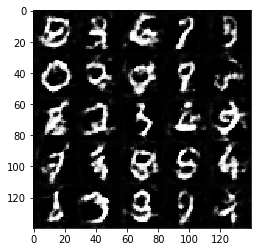

Epoch 1/2... Discriminator Loss: 0.3862... Generator Loss: 3.2415
Epoch 1/2... Discriminator Loss: 0.3989... Generator Loss: 3.0606
Epoch 1/2... Discriminator Loss: 0.3840... Generator Loss: 3.2150
Epoch 1/2... Discriminator Loss: 0.4928... Generator Loss: 4.9295
Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 3.5635
Epoch 1/2... Discriminator Loss: 0.3844... Generator Loss: 3.0795
Epoch 1/2... Discriminator Loss: 0.3960... Generator Loss: 3.1255
Epoch 1/2... Discriminator Loss: 0.3827... Generator Loss: 3.4758
Epoch 1/2... Discriminator Loss: 0.3834... Generator Loss: 3.0208
Epoch 1/2... Discriminator Loss: 0.3909... Generator Loss: 3.6789


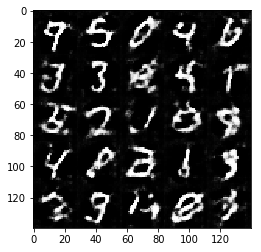

Epoch 1/2... Discriminator Loss: 0.3839... Generator Loss: 3.7236
Epoch 1/2... Discriminator Loss: 0.3963... Generator Loss: 3.9185
Epoch 1/2... Discriminator Loss: 0.3929... Generator Loss: 3.3961
Epoch 1/2... Discriminator Loss: 0.4196... Generator Loss: 2.8756
Epoch 1/2... Discriminator Loss: 0.3972... Generator Loss: 3.5822
Epoch 1/2... Discriminator Loss: 0.3994... Generator Loss: 3.0353
Epoch 1/2... Discriminator Loss: 0.4048... Generator Loss: 3.0791
Epoch 1/2... Discriminator Loss: 0.3847... Generator Loss: 3.2000
Epoch 1/2... Discriminator Loss: 0.3932... Generator Loss: 3.2224
Epoch 1/2... Discriminator Loss: 0.3855... Generator Loss: 3.0902


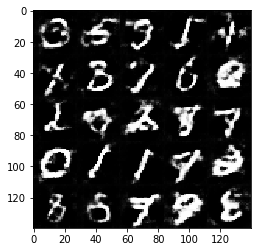

Epoch 1/2... Discriminator Loss: 0.4053... Generator Loss: 4.1030
Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 2.9177
Epoch 1/2... Discriminator Loss: 0.3879... Generator Loss: 3.2171
Epoch 1/2... Discriminator Loss: 0.3836... Generator Loss: 3.4905
Epoch 1/2... Discriminator Loss: 0.3810... Generator Loss: 3.7561
Epoch 1/2... Discriminator Loss: 0.4040... Generator Loss: 2.8452
Epoch 1/2... Discriminator Loss: 0.3770... Generator Loss: 3.2050
Epoch 1/2... Discriminator Loss: 0.3994... Generator Loss: 3.2123
Epoch 1/2... Discriminator Loss: 0.3890... Generator Loss: 3.1897
Epoch 1/2... Discriminator Loss: 0.3974... Generator Loss: 3.0656


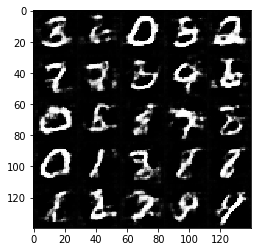

Epoch 1/2... Discriminator Loss: 0.3847... Generator Loss: 3.6170
Epoch 1/2... Discriminator Loss: 0.3883... Generator Loss: 3.1940
Epoch 1/2... Discriminator Loss: 0.3912... Generator Loss: 3.3817
Epoch 1/2... Discriminator Loss: 0.3889... Generator Loss: 3.3524
Epoch 1/2... Discriminator Loss: 0.3995... Generator Loss: 2.8856
Epoch 1/2... Discriminator Loss: 0.3988... Generator Loss: 2.9373
Epoch 1/2... Discriminator Loss: 0.3891... Generator Loss: 2.9665
Epoch 1/2... Discriminator Loss: 0.3863... Generator Loss: 3.2807
Epoch 1/2... Discriminator Loss: 0.3875... Generator Loss: 3.2261
Epoch 1/2... Discriminator Loss: 0.3793... Generator Loss: 3.0655


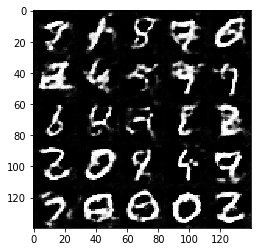

Epoch 1/2... Discriminator Loss: 0.4430... Generator Loss: 2.5160
Epoch 1/2... Discriminator Loss: 0.3973... Generator Loss: 3.6180
Epoch 1/2... Discriminator Loss: 0.3848... Generator Loss: 3.3102
Epoch 1/2... Discriminator Loss: 0.3939... Generator Loss: 2.9418
Epoch 1/2... Discriminator Loss: 0.3770... Generator Loss: 3.1570
Epoch 1/2... Discriminator Loss: 0.3872... Generator Loss: 3.4364
Epoch 1/2... Discriminator Loss: 0.3936... Generator Loss: 3.5853
Epoch 2/2... Discriminator Loss: 0.4005... Generator Loss: 3.1089
Epoch 2/2... Discriminator Loss: 0.3944... Generator Loss: 3.2525
Epoch 2/2... Discriminator Loss: 0.3889... Generator Loss: 3.3803


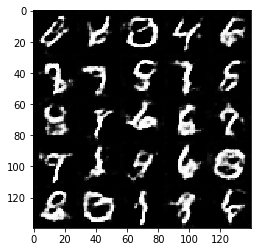

Epoch 2/2... Discriminator Loss: 0.3941... Generator Loss: 3.2631
Epoch 2/2... Discriminator Loss: 0.3825... Generator Loss: 3.4005
Epoch 2/2... Discriminator Loss: 0.3944... Generator Loss: 3.0487
Epoch 2/2... Discriminator Loss: 0.3852... Generator Loss: 3.2007
Epoch 2/2... Discriminator Loss: 0.4111... Generator Loss: 4.0543
Epoch 2/2... Discriminator Loss: 0.3808... Generator Loss: 3.2534
Epoch 2/2... Discriminator Loss: 0.3840... Generator Loss: 3.2905
Epoch 2/2... Discriminator Loss: 0.3857... Generator Loss: 3.2542
Epoch 2/2... Discriminator Loss: 0.3911... Generator Loss: 3.4774
Epoch 2/2... Discriminator Loss: 0.3928... Generator Loss: 3.2335


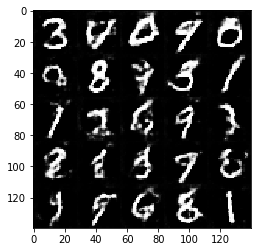

Epoch 2/2... Discriminator Loss: 0.3927... Generator Loss: 3.8237
Epoch 2/2... Discriminator Loss: 0.3910... Generator Loss: 3.8672
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 3.5709
Epoch 2/2... Discriminator Loss: 0.4001... Generator Loss: 2.9046
Epoch 2/2... Discriminator Loss: 0.3985... Generator Loss: 2.8859
Epoch 2/2... Discriminator Loss: 0.3898... Generator Loss: 3.1502
Epoch 2/2... Discriminator Loss: 0.3962... Generator Loss: 3.1344
Epoch 2/2... Discriminator Loss: 0.3771... Generator Loss: 3.3051
Epoch 2/2... Discriminator Loss: 0.3837... Generator Loss: 3.1793
Epoch 2/2... Discriminator Loss: 0.3839... Generator Loss: 3.2450


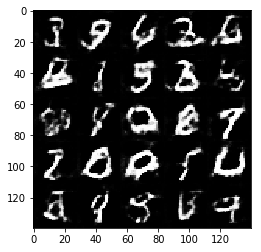

Epoch 2/2... Discriminator Loss: 0.3894... Generator Loss: 3.3381
Epoch 2/2... Discriminator Loss: 0.3804... Generator Loss: 3.6187
Epoch 2/2... Discriminator Loss: 0.3882... Generator Loss: 3.1183
Epoch 2/2... Discriminator Loss: 0.3946... Generator Loss: 3.7242
Epoch 2/2... Discriminator Loss: 0.3898... Generator Loss: 3.1035
Epoch 2/2... Discriminator Loss: 0.3855... Generator Loss: 3.1878
Epoch 2/2... Discriminator Loss: 0.3874... Generator Loss: 3.2541
Epoch 2/2... Discriminator Loss: 0.3916... Generator Loss: 3.1855
Epoch 2/2... Discriminator Loss: 0.3858... Generator Loss: 3.1848
Epoch 2/2... Discriminator Loss: 0.3923... Generator Loss: 3.7928


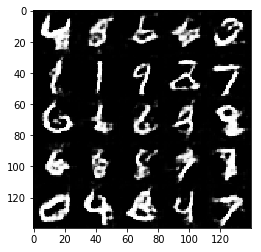

Epoch 2/2... Discriminator Loss: 0.4069... Generator Loss: 2.9580
Epoch 2/2... Discriminator Loss: 0.3905... Generator Loss: 3.1293
Epoch 2/2... Discriminator Loss: 0.3924... Generator Loss: 3.1818
Epoch 2/2... Discriminator Loss: 0.4053... Generator Loss: 4.0667
Epoch 2/2... Discriminator Loss: 0.3868... Generator Loss: 3.1456
Epoch 2/2... Discriminator Loss: 0.3879... Generator Loss: 3.1190
Epoch 2/2... Discriminator Loss: 0.3880... Generator Loss: 3.7547
Epoch 2/2... Discriminator Loss: 0.4581... Generator Loss: 2.3511
Epoch 2/2... Discriminator Loss: 0.4090... Generator Loss: 2.5928
Epoch 2/2... Discriminator Loss: 0.3920... Generator Loss: 3.0005


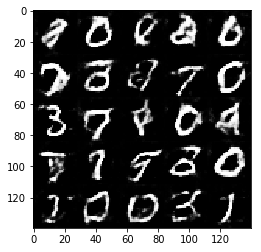

Epoch 2/2... Discriminator Loss: 0.3959... Generator Loss: 3.0239
Epoch 2/2... Discriminator Loss: 0.3784... Generator Loss: 3.2265
Epoch 2/2... Discriminator Loss: 0.3913... Generator Loss: 3.2791
Epoch 2/2... Discriminator Loss: 0.3840... Generator Loss: 3.3143
Epoch 2/2... Discriminator Loss: 0.3861... Generator Loss: 3.3008
Epoch 2/2... Discriminator Loss: 0.3948... Generator Loss: 3.8393
Epoch 2/2... Discriminator Loss: 0.3940... Generator Loss: 3.1768
Epoch 2/2... Discriminator Loss: 0.3859... Generator Loss: 3.2882
Epoch 2/2... Discriminator Loss: 0.3906... Generator Loss: 2.9074
Epoch 2/2... Discriminator Loss: 0.4008... Generator Loss: 2.8929


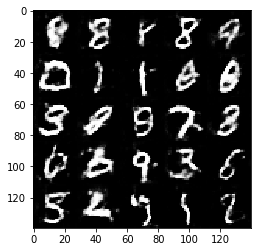

Epoch 2/2... Discriminator Loss: 0.3921... Generator Loss: 2.9373
Epoch 2/2... Discriminator Loss: 0.3872... Generator Loss: 3.5634
Epoch 2/2... Discriminator Loss: 0.3899... Generator Loss: 2.9936
Epoch 2/2... Discriminator Loss: 0.4014... Generator Loss: 3.0067
Epoch 2/2... Discriminator Loss: 0.3969... Generator Loss: 3.3465
Epoch 2/2... Discriminator Loss: 0.3913... Generator Loss: 3.3071
Epoch 2/2... Discriminator Loss: 0.3858... Generator Loss: 3.4946
Epoch 2/2... Discriminator Loss: 0.3851... Generator Loss: 3.3085
Epoch 2/2... Discriminator Loss: 0.3931... Generator Loss: 3.1828
Epoch 2/2... Discriminator Loss: 0.3984... Generator Loss: 3.1703


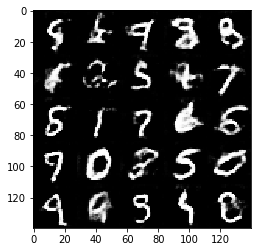

Epoch 2/2... Discriminator Loss: 0.3863... Generator Loss: 3.3261
Epoch 2/2... Discriminator Loss: 0.4067... Generator Loss: 2.5927
Epoch 2/2... Discriminator Loss: 0.3927... Generator Loss: 4.0037
Epoch 2/2... Discriminator Loss: 0.3849... Generator Loss: 3.1570
Epoch 2/2... Discriminator Loss: 0.3846... Generator Loss: 3.5914
Epoch 2/2... Discriminator Loss: 0.3764... Generator Loss: 3.2675
Epoch 2/2... Discriminator Loss: 0.3899... Generator Loss: 3.2412
Epoch 2/2... Discriminator Loss: 0.3772... Generator Loss: 3.4353
Epoch 2/2... Discriminator Loss: 0.3999... Generator Loss: 2.9486
Epoch 2/2... Discriminator Loss: 0.3904... Generator Loss: 3.3785


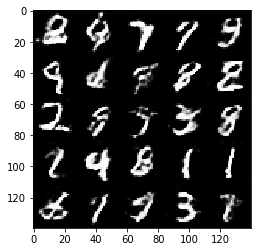

Epoch 2/2... Discriminator Loss: 0.3823... Generator Loss: 3.6277
Epoch 2/2... Discriminator Loss: 0.3932... Generator Loss: 2.9916
Epoch 2/2... Discriminator Loss: 0.4043... Generator Loss: 2.8686
Epoch 2/2... Discriminator Loss: 0.3891... Generator Loss: 3.4867
Epoch 2/2... Discriminator Loss: 0.3982... Generator Loss: 2.9124
Epoch 2/2... Discriminator Loss: 0.3904... Generator Loss: 2.9834
Epoch 2/2... Discriminator Loss: 0.3883... Generator Loss: 3.5819
Epoch 2/2... Discriminator Loss: 0.4078... Generator Loss: 2.8122
Epoch 2/2... Discriminator Loss: 0.4031... Generator Loss: 4.0261
Epoch 2/2... Discriminator Loss: 0.3820... Generator Loss: 3.5095


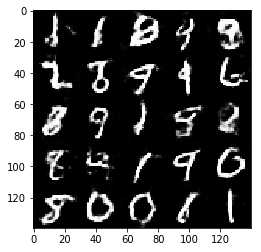

Epoch 2/2... Discriminator Loss: 0.3875... Generator Loss: 3.3837
Epoch 2/2... Discriminator Loss: 0.3926... Generator Loss: 3.0312
Epoch 2/2... Discriminator Loss: 0.3856... Generator Loss: 3.2267
Epoch 2/2... Discriminator Loss: 0.3810... Generator Loss: 3.5427
Epoch 2/2... Discriminator Loss: 0.3833... Generator Loss: 3.3224
Epoch 2/2... Discriminator Loss: 0.4008... Generator Loss: 2.9219
Epoch 2/2... Discriminator Loss: 0.3800... Generator Loss: 3.4233
Epoch 2/2... Discriminator Loss: 0.3951... Generator Loss: 3.2732
Epoch 2/2... Discriminator Loss: 0.3811... Generator Loss: 3.2911
Epoch 2/2... Discriminator Loss: 0.3888... Generator Loss: 3.2595


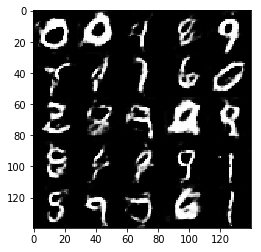

Epoch 2/2... Discriminator Loss: 0.3968... Generator Loss: 2.9045
Epoch 2/2... Discriminator Loss: 0.3762... Generator Loss: 3.4973
Epoch 2/2... Discriminator Loss: 0.4312... Generator Loss: 2.5124
Epoch 2/2... Discriminator Loss: 0.3865... Generator Loss: 3.2545
Epoch 2/2... Discriminator Loss: 0.3792... Generator Loss: 3.2368
Epoch 2/2... Discriminator Loss: 0.3907... Generator Loss: 3.8823
Epoch 2/2... Discriminator Loss: 0.3920... Generator Loss: 3.0389
Epoch 2/2... Discriminator Loss: 0.3761... Generator Loss: 3.4320
Epoch 2/2... Discriminator Loss: 0.3841... Generator Loss: 3.2349
Epoch 2/2... Discriminator Loss: 0.3820... Generator Loss: 3.3199


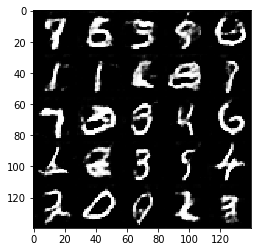

Epoch 2/2... Discriminator Loss: 0.3880... Generator Loss: 3.0443
Epoch 2/2... Discriminator Loss: 0.3997... Generator Loss: 2.9939
Epoch 2/2... Discriminator Loss: 0.3861... Generator Loss: 3.6037
Epoch 2/2... Discriminator Loss: 0.3872... Generator Loss: 3.6324
Epoch 2/2... Discriminator Loss: 0.3907... Generator Loss: 3.1139
Epoch 2/2... Discriminator Loss: 0.3848... Generator Loss: 3.1456
Epoch 2/2... Discriminator Loss: 0.3986... Generator Loss: 2.8894
Epoch 2/2... Discriminator Loss: 0.3886... Generator Loss: 3.0218
Epoch 2/2... Discriminator Loss: 0.3801... Generator Loss: 3.1743
Epoch 2/2... Discriminator Loss: 0.3837... Generator Loss: 3.3457


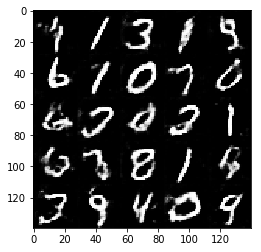

Epoch 2/2... Discriminator Loss: 0.3822... Generator Loss: 3.3378
Epoch 2/2... Discriminator Loss: 0.3894... Generator Loss: 3.8328
Epoch 2/2... Discriminator Loss: 0.3898... Generator Loss: 3.0088
Epoch 2/2... Discriminator Loss: 0.3799... Generator Loss: 3.2744
Epoch 2/2... Discriminator Loss: 0.3820... Generator Loss: 3.7170
Epoch 2/2... Discriminator Loss: 0.4028... Generator Loss: 2.8547
Epoch 2/2... Discriminator Loss: 0.4070... Generator Loss: 4.0378
Epoch 2/2... Discriminator Loss: 0.3751... Generator Loss: 3.4920
Epoch 2/2... Discriminator Loss: 0.3885... Generator Loss: 3.2662
Epoch 2/2... Discriminator Loss: 0.3787... Generator Loss: 3.5218


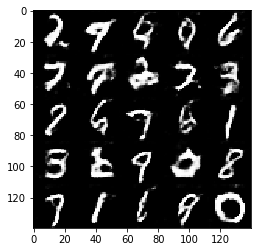

Epoch 2/2... Discriminator Loss: 0.3927... Generator Loss: 4.1227
Epoch 2/2... Discriminator Loss: 0.3854... Generator Loss: 3.3629
Epoch 2/2... Discriminator Loss: 0.3807... Generator Loss: 3.6471
Epoch 2/2... Discriminator Loss: 0.3714... Generator Loss: 3.5213
Epoch 2/2... Discriminator Loss: 0.3752... Generator Loss: 3.4448
Epoch 2/2... Discriminator Loss: 0.3875... Generator Loss: 3.0389
Epoch 2/2... Discriminator Loss: 0.3804... Generator Loss: 3.6452
Epoch 2/2... Discriminator Loss: 0.3848... Generator Loss: 3.1135
Epoch 2/2... Discriminator Loss: 0.3841... Generator Loss: 3.5289
Epoch 2/2... Discriminator Loss: 0.3828... Generator Loss: 3.6482


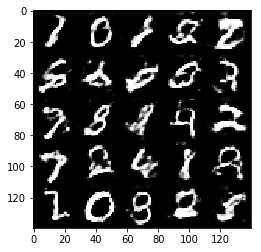

Epoch 2/2... Discriminator Loss: 0.3835... Generator Loss: 3.0910
Epoch 2/2... Discriminator Loss: 0.3868... Generator Loss: 3.6703
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 3.1347
Epoch 2/2... Discriminator Loss: 0.3862... Generator Loss: 3.7596
Epoch 2/2... Discriminator Loss: 0.3639... Generator Loss: 3.5205
Epoch 2/2... Discriminator Loss: 0.4180... Generator Loss: 2.7253
Epoch 2/2... Discriminator Loss: 0.3819... Generator Loss: 3.6652
Epoch 2/2... Discriminator Loss: 0.3705... Generator Loss: 3.6138
Epoch 2/2... Discriminator Loss: 0.3767... Generator Loss: 3.3164
Epoch 2/2... Discriminator Loss: 0.3860... Generator Loss: 3.0902


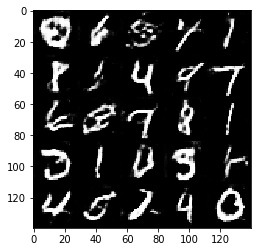

Epoch 2/2... Discriminator Loss: 0.3801... Generator Loss: 3.8154
Epoch 2/2... Discriminator Loss: 0.3868... Generator Loss: 3.3177
Epoch 2/2... Discriminator Loss: 0.3770... Generator Loss: 3.8006
Epoch 2/2... Discriminator Loss: 0.3958... Generator Loss: 2.8704
Epoch 2/2... Discriminator Loss: 0.3852... Generator Loss: 3.1362
Epoch 2/2... Discriminator Loss: 0.3860... Generator Loss: 3.3386
Epoch 2/2... Discriminator Loss: 0.3793... Generator Loss: 3.6544
Epoch 2/2... Discriminator Loss: 0.3996... Generator Loss: 2.8156
Epoch 2/2... Discriminator Loss: 0.3823... Generator Loss: 3.8902
Epoch 2/2... Discriminator Loss: 0.4033... Generator Loss: 3.8144


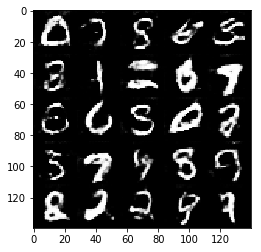

Epoch 2/2... Discriminator Loss: 0.3974... Generator Loss: 3.0985
Epoch 2/2... Discriminator Loss: 0.3751... Generator Loss: 3.3847
Epoch 2/2... Discriminator Loss: 0.3844... Generator Loss: 3.0102
Epoch 2/2... Discriminator Loss: 0.3783... Generator Loss: 4.0481
Epoch 2/2... Discriminator Loss: 0.3861... Generator Loss: 3.3089
Epoch 2/2... Discriminator Loss: 0.3637... Generator Loss: 3.5335
Epoch 2/2... Discriminator Loss: 0.3864... Generator Loss: 3.0928
Epoch 2/2... Discriminator Loss: 0.3834... Generator Loss: 3.2297
Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 3.5412
Epoch 2/2... Discriminator Loss: 0.3875... Generator Loss: 3.8992


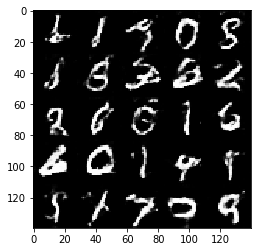

Epoch 2/2... Discriminator Loss: 0.3744... Generator Loss: 3.2112
Epoch 2/2... Discriminator Loss: 0.3792... Generator Loss: 3.1358
Epoch 2/2... Discriminator Loss: 0.3768... Generator Loss: 3.8828
Epoch 2/2... Discriminator Loss: 0.3788... Generator Loss: 3.4621
Epoch 2/2... Discriminator Loss: 0.3788... Generator Loss: 3.2924
Epoch 2/2... Discriminator Loss: 0.3853... Generator Loss: 4.0785
Epoch 2/2... Discriminator Loss: 0.3715... Generator Loss: 3.3933
Epoch 2/2... Discriminator Loss: 0.3802... Generator Loss: 3.2231
Epoch 2/2... Discriminator Loss: 0.3759... Generator Loss: 3.4862
Epoch 2/2... Discriminator Loss: 0.3723... Generator Loss: 3.6309


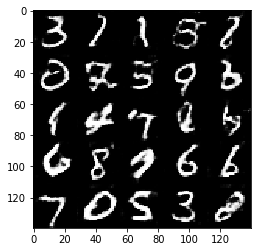

Epoch 2/2... Discriminator Loss: 0.3806... Generator Loss: 3.1542
Epoch 2/2... Discriminator Loss: 0.3743... Generator Loss: 3.1890
Epoch 2/2... Discriminator Loss: 0.3715... Generator Loss: 3.7539
Epoch 2/2... Discriminator Loss: 0.3814... Generator Loss: 3.1742
Epoch 2/2... Discriminator Loss: 0.3840... Generator Loss: 3.6649
Epoch 2/2... Discriminator Loss: 0.3777... Generator Loss: 3.2827
Epoch 2/2... Discriminator Loss: 0.3953... Generator Loss: 3.7757
Epoch 2/2... Discriminator Loss: 0.3651... Generator Loss: 3.6517
Epoch 2/2... Discriminator Loss: 0.5458... Generator Loss: 2.1286
Epoch 2/2... Discriminator Loss: 0.3791... Generator Loss: 3.4316


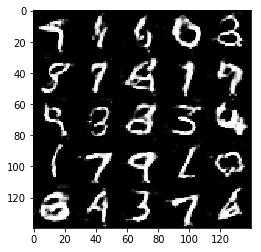

Epoch 2/2... Discriminator Loss: 0.3790... Generator Loss: 3.4590
Epoch 2/2... Discriminator Loss: 0.3761... Generator Loss: 3.3104
Epoch 2/2... Discriminator Loss: 0.3911... Generator Loss: 3.5144
Epoch 2/2... Discriminator Loss: 0.3722... Generator Loss: 3.3594
Epoch 2/2... Discriminator Loss: 0.3774... Generator Loss: 3.7036


In [299]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print("mnist_dataset.shape: ",mnist_dataset.shape)
print("mnist_dataset.image_mode: ",mnist_dataset.image_mode)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

data_shape: (202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 2.2144... Generator Loss: 0.3464
Epoch 1/1... Discriminator Loss: 0.7196... Generator Loss: 9.0848
Epoch 1/1... Discriminator Loss: 0.4563... Generator Loss: 4.1272
Epoch 1/1... Discriminator Loss: 0.4627... Generator Loss: 2.5812
Epoch 1/1... Discriminator Loss: 0.4217... Generator Loss: 3.6648
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 3.2861
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 3.2673
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 3.2876
Epoch 1/1... Discriminator Loss: 0.3962... Generator Loss: 3.8306
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 3.7494


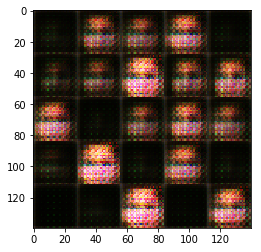

Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 6.2007
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 3.8935
Epoch 1/1... Discriminator Loss: 0.4165... Generator Loss: 3.0297
Epoch 1/1... Discriminator Loss: 0.4027... Generator Loss: 3.5274
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 3.4869
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 3.6607
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 3.4995
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 3.4450
Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 2.7368
Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 2.9439


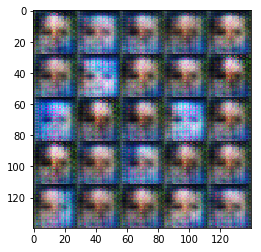

Epoch 1/1... Discriminator Loss: 0.3659... Generator Loss: 4.0412
Epoch 1/1... Discriminator Loss: 0.3869... Generator Loss: 3.6747
Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 2.7322
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 3.5498
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 3.8500
Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 3.4396
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 3.8649
Epoch 1/1... Discriminator Loss: 0.4531... Generator Loss: 4.4812
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 3.6068
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 2.9735


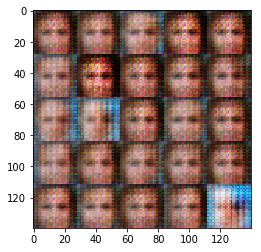

Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 4.1544
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 3.9099
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 4.1180
Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 3.4702
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 4.1749
Epoch 1/1... Discriminator Loss: 0.3895... Generator Loss: 3.4649
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 3.2216
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 3.2463
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 3.1643
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 3.5516


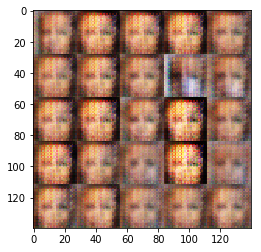

Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 4.0981
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 3.5763
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 2.9156
Epoch 1/1... Discriminator Loss: 0.3814... Generator Loss: 3.5621
Epoch 1/1... Discriminator Loss: 0.4234... Generator Loss: 3.6067
Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 3.6226
Epoch 1/1... Discriminator Loss: 0.3803... Generator Loss: 3.4882
Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 3.1486
Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 3.9758
Epoch 1/1... Discriminator Loss: 0.3816... Generator Loss: 3.5587


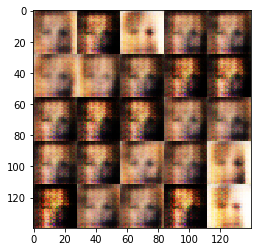

Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 3.1778
Epoch 1/1... Discriminator Loss: 0.4088... Generator Loss: 3.1170
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 3.2669
Epoch 1/1... Discriminator Loss: 0.4164... Generator Loss: 3.1035
Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 3.7862
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 3.2146
Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 3.2238
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 3.2739
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 2.9335
Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 3.2205


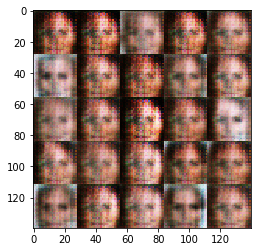

Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 2.9392
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 3.0558
Epoch 1/1... Discriminator Loss: 0.4200... Generator Loss: 3.3221
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 3.8957
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 3.2403
Epoch 1/1... Discriminator Loss: 0.3704... Generator Loss: 3.7621
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 3.4242
Epoch 1/1... Discriminator Loss: 0.3958... Generator Loss: 3.3096
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 3.7564
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 3.3444


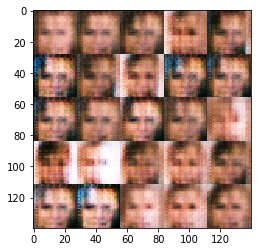

Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 3.2217
Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 3.8337
Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 3.6354
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 3.2905
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 4.6945
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 3.8466
Epoch 1/1... Discriminator Loss: 0.3971... Generator Loss: 3.2868
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 3.5478
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 2.7333
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 3.2975


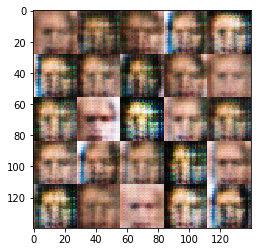

Epoch 1/1... Discriminator Loss: 0.3872... Generator Loss: 3.6709
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 3.5255
Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 3.5510
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 3.2033
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 3.2324
Epoch 1/1... Discriminator Loss: 0.4190... Generator Loss: 2.8957
Epoch 1/1... Discriminator Loss: 0.3830... Generator Loss: 3.5797
Epoch 1/1... Discriminator Loss: 0.3721... Generator Loss: 3.6055
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 4.0437
Epoch 1/1... Discriminator Loss: 0.3933... Generator Loss: 2.9746


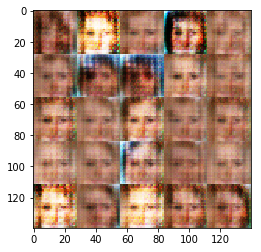

Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 3.4323
Epoch 1/1... Discriminator Loss: 0.4020... Generator Loss: 3.0173
Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 3.6279
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.1050
Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 3.2044
Epoch 1/1... Discriminator Loss: 0.4174... Generator Loss: 3.8249
Epoch 1/1... Discriminator Loss: 0.4021... Generator Loss: 3.0579
Epoch 1/1... Discriminator Loss: 0.4181... Generator Loss: 3.0793
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 3.8399
Epoch 1/1... Discriminator Loss: 0.4320... Generator Loss: 2.5695


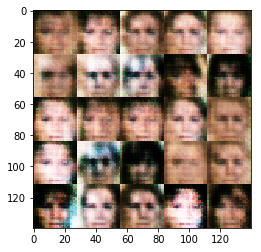

Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 3.4691
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 3.4786
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 3.1110
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 3.5359
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 3.5960
Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 3.3571
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 3.4070
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 3.0674
Epoch 1/1... Discriminator Loss: 0.4030... Generator Loss: 3.1069
Epoch 1/1... Discriminator Loss: 0.3616... Generator Loss: 4.1368


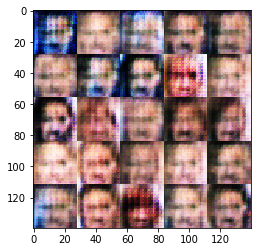

Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 3.2255
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.9238
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 4.3623
Epoch 1/1... Discriminator Loss: 0.4119... Generator Loss: 3.1245
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 3.3642
Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 3.3215
Epoch 1/1... Discriminator Loss: 0.3692... Generator Loss: 3.6884
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 3.1241
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 3.5030
Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 4.4045


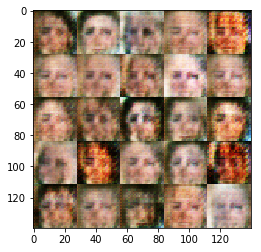

Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 3.3618
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 3.6068
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 3.6739
Epoch 1/1... Discriminator Loss: 0.3844... Generator Loss: 3.4751
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 3.0557
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 2.9308
Epoch 1/1... Discriminator Loss: 0.3786... Generator Loss: 3.3187
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 3.4823
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 3.0999
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 3.4103


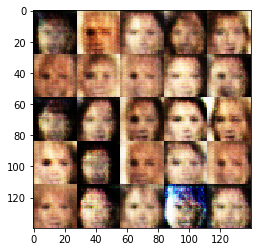

Epoch 1/1... Discriminator Loss: 0.4007... Generator Loss: 2.9606
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 3.5363
Epoch 1/1... Discriminator Loss: 0.3708... Generator Loss: 3.6963
Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 4.2122
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 2.9161
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 3.6155
Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 3.3839
Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 4.2917
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 4.6477
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 3.5140


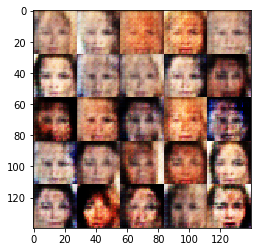

Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 3.2832
Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 3.4033
Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 3.2012
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 3.3301
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 3.3423
Epoch 1/1... Discriminator Loss: 0.3845... Generator Loss: 3.4548
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 2.7845
Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 2.6804
Epoch 1/1... Discriminator Loss: 0.4174... Generator Loss: 2.9790
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 3.3885


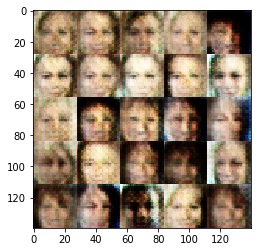

Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 2.9978
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.0460
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 2.9714
Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 3.1019
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 3.2576
Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 4.1936
Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 4.0393
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 3.1847
Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 3.1798
Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 3.7498


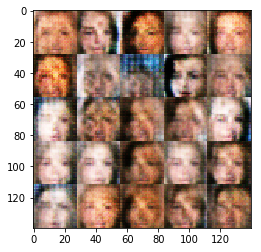

Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 3.4238
Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 3.1148
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 3.5866
Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 2.4747
Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 3.8351
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 3.2699
Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 3.5718
Epoch 1/1... Discriminator Loss: 0.4118... Generator Loss: 2.6643
Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 3.8842
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 3.1216


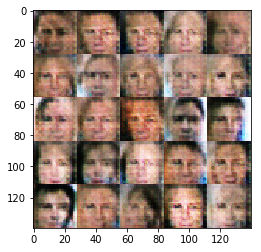

Epoch 1/1... Discriminator Loss: 0.3784... Generator Loss: 3.2837
Epoch 1/1... Discriminator Loss: 0.3955... Generator Loss: 2.8498
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 3.5660
Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 2.9368
Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 3.5605
Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 3.0934
Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 4.0112
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 3.1303
Epoch 1/1... Discriminator Loss: 0.4168... Generator Loss: 3.7642
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 3.4166


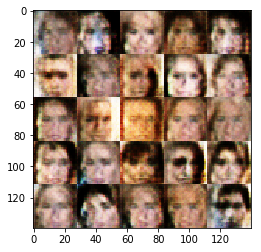

Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 3.0301
Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 3.0128
Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 2.6062
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 3.3047
Epoch 1/1... Discriminator Loss: 0.3870... Generator Loss: 3.1965
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 3.3133
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 2.9654
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 3.7670
Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 3.6835
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 2.9586


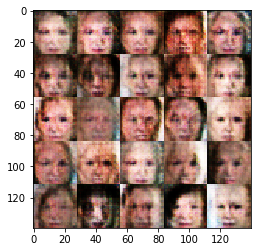

Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 3.3694
Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 3.3657
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 2.9512
Epoch 1/1... Discriminator Loss: 0.4421... Generator Loss: 3.4596
Epoch 1/1... Discriminator Loss: 0.4310... Generator Loss: 2.4550
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 3.0692
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 3.5134
Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 3.0371
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 3.3038
Epoch 1/1... Discriminator Loss: 0.4030... Generator Loss: 2.9680


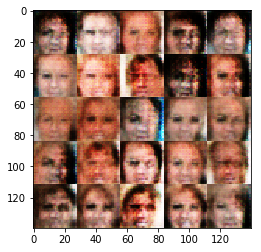

Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 3.0632
Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 3.0322
Epoch 1/1... Discriminator Loss: 0.4140... Generator Loss: 3.2769
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 3.1518
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 3.0597
Epoch 1/1... Discriminator Loss: 0.3946... Generator Loss: 2.9808
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 3.3006
Epoch 1/1... Discriminator Loss: 0.4414... Generator Loss: 3.9472
Epoch 1/1... Discriminator Loss: 0.3821... Generator Loss: 3.1521
Epoch 1/1... Discriminator Loss: 0.4102... Generator Loss: 3.3233


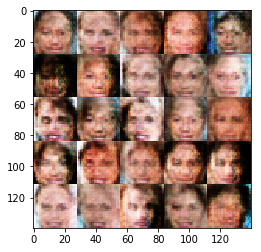

Epoch 1/1... Discriminator Loss: 0.4148... Generator Loss: 3.8962
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 3.6237
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 3.4237
Epoch 1/1... Discriminator Loss: 0.4035... Generator Loss: 3.0710
Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 2.9178
Epoch 1/1... Discriminator Loss: 0.4846... Generator Loss: 4.0533
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 3.2521
Epoch 1/1... Discriminator Loss: 0.4017... Generator Loss: 3.1070
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 3.0207
Epoch 1/1... Discriminator Loss: 0.3933... Generator Loss: 3.0459


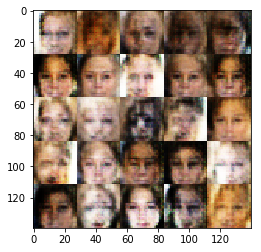

Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 3.0829
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 3.2983
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 3.4853
Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 3.3296
Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 3.7105
Epoch 1/1... Discriminator Loss: 0.3797... Generator Loss: 3.5132
Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 3.2065
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 3.1875
Epoch 1/1... Discriminator Loss: 0.4217... Generator Loss: 2.9594
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 3.1742


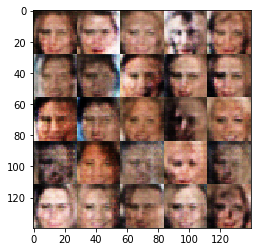

Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 3.1706
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 2.9599
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 3.2916
Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 3.1625
Epoch 1/1... Discriminator Loss: 0.3958... Generator Loss: 3.2249
Epoch 1/1... Discriminator Loss: 0.4812... Generator Loss: 3.7741
Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 3.0579
Epoch 1/1... Discriminator Loss: 0.3896... Generator Loss: 3.2766
Epoch 1/1... Discriminator Loss: 0.4226... Generator Loss: 2.6180
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 3.3203


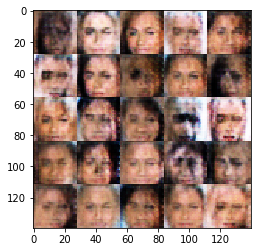

Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 2.9063
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 3.7199
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 3.3485
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 3.1692
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 3.1085
Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 3.6965
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 2.9486
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 3.2685
Epoch 1/1... Discriminator Loss: 0.3928... Generator Loss: 2.9703
Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 3.1453


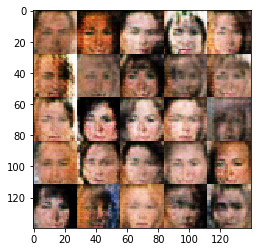

Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 3.2750
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 3.1732
Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 3.2881
Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 3.1649
Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 3.1804
Epoch 1/1... Discriminator Loss: 0.3921... Generator Loss: 3.4181
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 3.2662
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 3.0950
Epoch 1/1... Discriminator Loss: 0.3962... Generator Loss: 3.6151
Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 2.9934


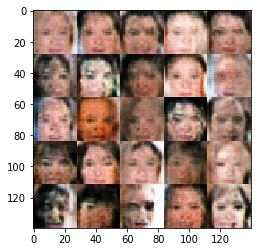

Epoch 1/1... Discriminator Loss: 0.4044... Generator Loss: 2.9608
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 2.8868
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 2.8455
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 3.0329
Epoch 1/1... Discriminator Loss: 0.3945... Generator Loss: 3.2990
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 2.8659
Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 3.0920
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 2.9320
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 3.1245
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 3.0450


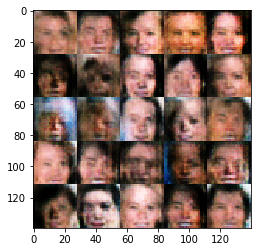

Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 3.2302
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 3.0682
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 2.8864
Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 3.0975
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 3.0064
Epoch 1/1... Discriminator Loss: 0.3869... Generator Loss: 3.4216
Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 2.7375
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 2.8848
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 3.0242
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 2.9487


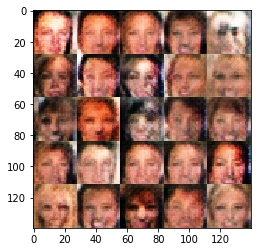

Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 3.1816
Epoch 1/1... Discriminator Loss: 0.3955... Generator Loss: 3.3891
Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 3.2720
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 3.1510
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 3.4966
Epoch 1/1... Discriminator Loss: 0.3979... Generator Loss: 3.4145
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 3.1629
Epoch 1/1... Discriminator Loss: 0.3928... Generator Loss: 3.3334
Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 2.9073
Epoch 1/1... Discriminator Loss: 0.3870... Generator Loss: 3.1495


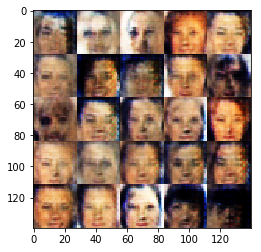

Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 3.0074
Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 3.0072
Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 3.0727
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.2653
Epoch 1/1... Discriminator Loss: 0.4050... Generator Loss: 3.8709
Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 3.2601
Epoch 1/1... Discriminator Loss: 0.4141... Generator Loss: 3.7501
Epoch 1/1... Discriminator Loss: 0.3875... Generator Loss: 3.2000
Epoch 1/1... Discriminator Loss: 0.3844... Generator Loss: 3.5054
Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 3.0938


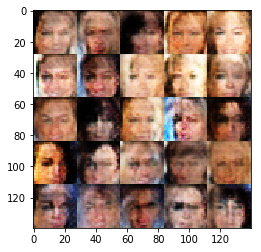

Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 2.7921
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 3.3571
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 3.3095
Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 3.1159
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 3.2158
Epoch 1/1... Discriminator Loss: 0.4154... Generator Loss: 3.0516
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 3.1247
Epoch 1/1... Discriminator Loss: 0.4244... Generator Loss: 4.0296
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 3.2940
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 3.2290


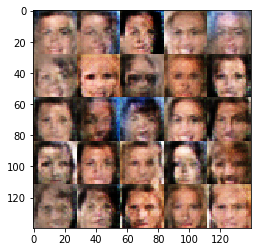

Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 3.0675
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 3.7076
Epoch 1/1... Discriminator Loss: 0.4164... Generator Loss: 3.0614
Epoch 1/1... Discriminator Loss: 0.3963... Generator Loss: 3.0929
Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 3.2341
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 3.2677


In [300]:
batch_size = 16
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。